# Classification d'images de chiens et de chats

Dans ce TP, on s'intéresse au problème simple (en apparence) de reconnaître des chiens et des chats dans des images.

<center> <img src="https://drive.google.com/uc?id=11W1SmzrBhL8vyzPCjSkZfHWnxb7kByi5" style="width:1000;height:550px;"></center>
<caption><center><b> Figure 1 : Quelques images de la base de données </b></center></caption>

Pour cela nous allons utiliser une base de données de 4000 images, réparties en 2000 images d'apprentissage, 1000 images de validation, et 1000 images de test. Compte-tenu de la variabilité possible des représentations de chiens et chats, cette base de données est d'une taille assez réduite et le problème est complexe. Il correspond bien aux problèmes que nous pouvons rencontrer dans la réalité, lorsque les données sont souvent difficiles à obtenir.


Il faut définir une résolution commune à toutes les images, qui sera donc la dimension passée en entrée au réseau de neurones. Pour commencer et simplifier le problème, vous pouvez d'abord considérer des images de taille $64 \times 64$ ; plus tard, lorsque vos réseaux fonctionneront bien, nous pourrons envisager d'augmenter cette résolution pour améliorer les performances.  

In [9]:
IMAGE_SIZE = 64
CLASSES = ['cat', 'dog']

## Chargement des données
La base de données est à télécharger depuis Git. Ne passez pas trop de temps à regarder les cellules suivantes (mais exécutez les !).

In [10]:
!git clone https://github.com/axelcarlier/iam.git
path = "./iam/tp3/"

fatal: destination path 'iam' already exists and is not an empty directory.


Chargement des données dans des tenseurs $x$ et $y$ de dimensions respectives $(N, 64, 64, 3)$ et $(N, 1)$, où $N$ désigne le nombre d'éléments de l'ensemble considéré (apprentissage, validation, ou test).

In [11]:
import glob
import PIL
from PIL import Image
import numpy as np

def load_data(path, classes, image_size=64):

  # Liste les fichiers présents dans le dossier path
  file_path = glob.glob(path)

  # Initialise les structures de données
  x = np.zeros((len(file_path), image_size, image_size, 3))
  y = np.zeros((len(file_path), 1))

  for i in range(len(file_path)):
    # Lecture de l'image
    img = Image.open(file_path[i])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    img_path_split = file_path[i].split('/')
    img_name_split = img_path_split[-1].split('.')
    class_label = classes.index(img_name_split[-3])

    y[i] = class_label

  return x, y

x_train, y_train = load_data('./iam/tp3/train/*', CLASSES, image_size=IMAGE_SIZE)
x_val, y_val = load_data('./iam/tp3/validation/*', CLASSES, image_size=IMAGE_SIZE)
x_test, y_test = load_data('./iam/tp3/test/*', CLASSES, image_size=IMAGE_SIZE)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Visualisation des images

/var/folders/qz/rqhm_f915_v35yxhmxqd2fdr0000gn/T/ipykernel_96472/3709099208.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(CLASSES[int(y_train[i])])


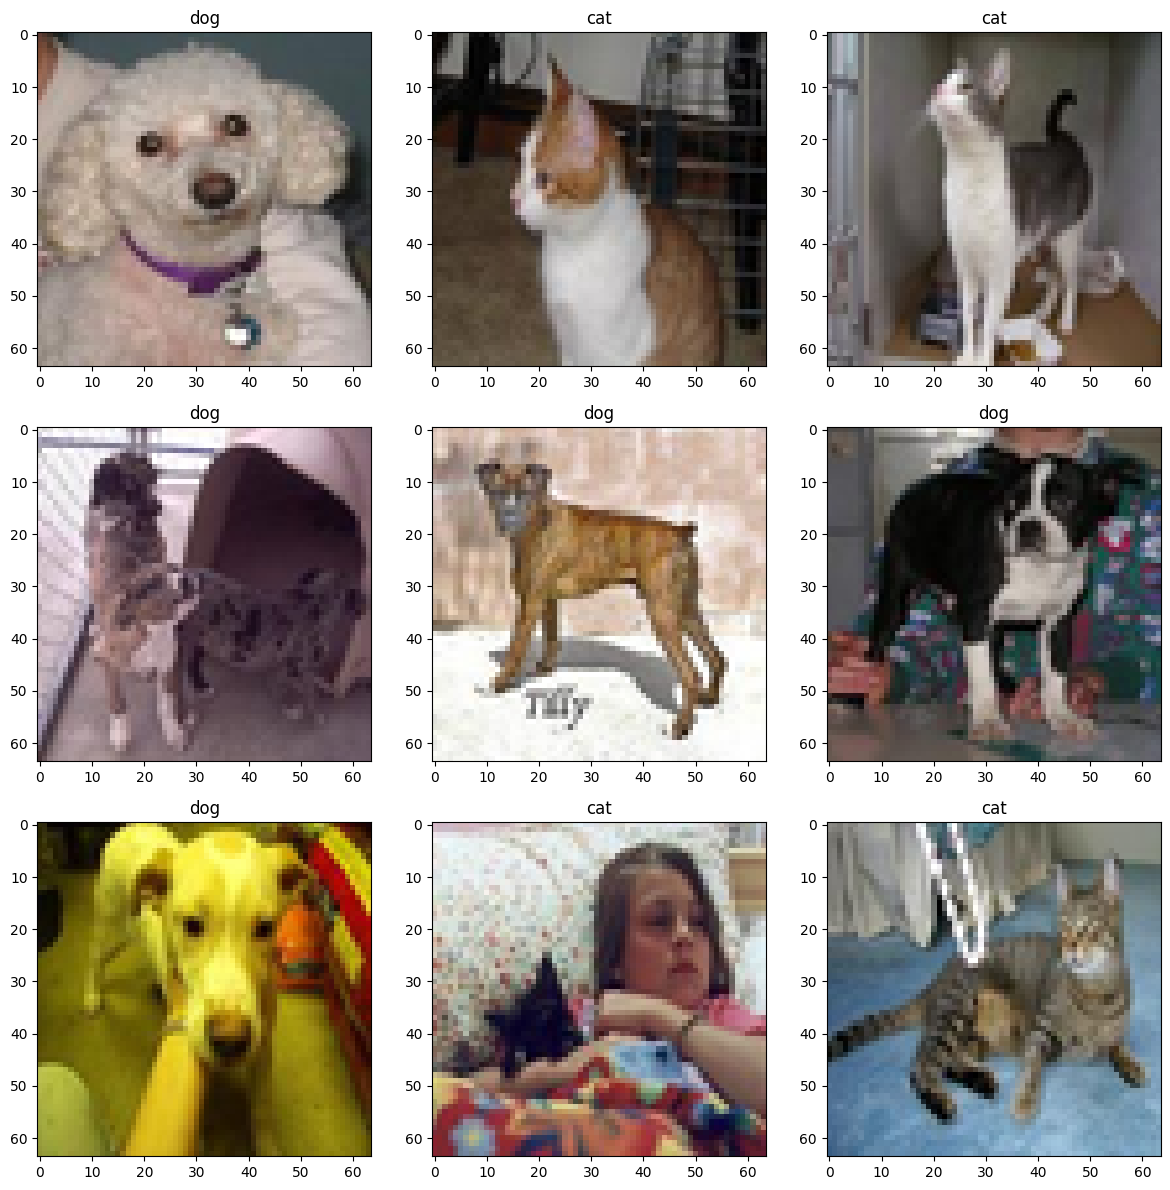

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Randomisation des indices et affichage de 9 images alétoires de la base d'apprentissage
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y_train[i])])
    plt.imshow(x_train[i])
plt.tight_layout()
plt.show()

## Première approche : réseau convolutif de base

Les images ont toutes été redimensionnées en $64 \times 64$.
Vous devez définir un réseau de neurones convolutif en suivant ce schéma pour la base convolutive :

<center> <img src="https://drive.google.com/uc?id=1bwXaIgO-pKJGs6fVaX0IrLbFbUAlTvNM" style="width:800;height:400px;"></center>
<caption><center><b> Figure 2: Vue de l'architecture à implémenter </b></center></caption>

Ce réseau alterne dans une première phase les couches de convolution et de Max Pooling (afin de diviser à chaque fois la dimension des tenseurs par 2).

La première couche comptera 32 filtres de convolution, la seconde 64, la troisième 96 et la 4e 128.
Une fois la partie convolutive de votre réseau achevée, vous devez vectoriser le tenseur de sortie à l'aide d'une couche *Flatten*.
Vous pouvez ensuite ajouter une couche dense de 512 neurones, avant de terminer avec la couche de sortie. **A vous de déterminer le nombre de neurones et l'activation de sortie adaptés au problème que nous traitons !**

Vous aurez donc construit un réseau à 6 couches, sorte de version simplifiée d'AlexNet.

Pour construire ce réseau, vous pouvez utiliser les fonctions Conv2D, Maxpooling2D, et Flatten de Keras.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()

## 1ère couche :
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2))

## 2ème couche :
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

## 3ème couche :
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

## 4ème couche :
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

## Flatten
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense

## Prédicteur
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(1, activation='sigmoid'))   # Couche de sortie

/opt/homebrew/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,673 (1.71 MB)

 Trainable params: 448,673 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

### Entrainement

Pour l'entraînement, vous pouvez utiliser directement les hyperparamètres suivants.

In [28]:
from tensorflow.keras import optimizers

model.compile(loss='bce',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

... puis lancer l'entraînement. **Attention : si jamais vous voulez relancer l'entraînement, il faut réinitialiser les poids du réseau. Pour cela il faut re-exécuter les cellules précédentes à partir de la définition du réseau !** Sinon vous risquez de repartir d'un entraînement précédent (qui s'est éventuellement bien, ou mal déroulé) et mal interpréter votre nouvel entraînement.

In [29]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=10)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5370 - loss: 0.6919 - val_accuracy: 0.5020 - val_loss: 0.6905
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6000 - loss: 0.6658 - val_accuracy: 0.5660 - val_loss: 0.6877
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6700 - loss: 0.6136 - val_accuracy: 0.5940 - val_loss: 0.7137
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7220 - loss: 0.5471 - val_accuracy: 0.6530 - val_loss: 0.6809
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7625 - loss: 0.4838 - val_accuracy: 0.6990 - val_loss: 0.5861
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8015 - loss: 0.4308 - val_accuracy: 0.7220 - val_loss: 0.5551
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8445 - loss: 0.3578 - val_accuracy: 0.7110 - val_loss: 0.6371
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8750 - loss: 0.3022 - val_accu

### Analyse des résultats du modèle

Les quelques lignes suivantes permettent d'afficher l'évolution des métriques au cours de l'entraînement, sur les ensembles d'apprentissage et de validation.

In [30]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

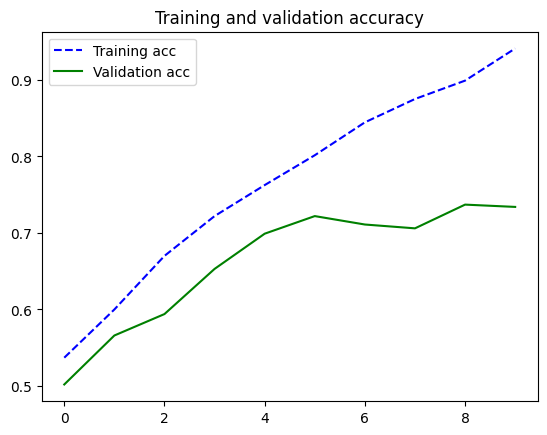

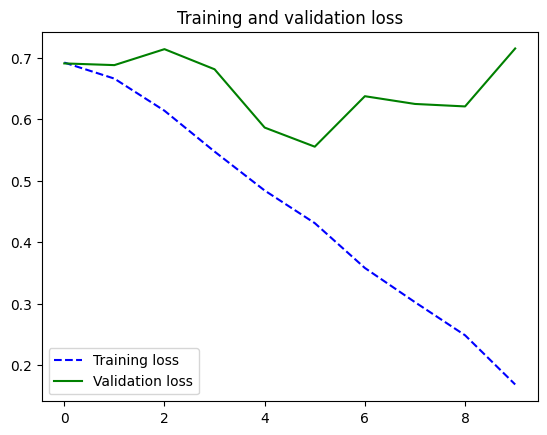

In [31]:
plot_training_analysis()

### Correction du surapprentissage

Vous devriez reconnaître le problème auquel vous avez affaire : **le surapprentissage**. Ce problème est classique dès lors que l'on travaille sur des bases de données de taille réduite en apprentissage profond.
 En effet, le réseau que vous avez créé compte normalement (si vous avez suivi les indications) plusieurs centaines de milliers de paramètres. Le problème que vous essayez de résoudre pendant l'entraînement consiste à établir 450 000 paramètres avec seulement 2000 exemples : c'est trop peu !

Afin de limiter ce surapprentissage, nous pouvons appliquer les techniques de régularisation vues pendant le 2nd cours. En traitement d'image, une des techniques les plus couramment utilisées est **l'augmentation de la base de données**.

Nous allons introduire un objet *ImageDataGenerator* pour appliquer des transformations supplémentaires aux images de notre base de données. A vous de chercher dans la documentation à quoi correspondent les différents paramètres présentés ci-dessous.

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


La cellule suivante vous permet de visualiser des images passées à travers notre boucle d'augmentation de données. Observez comment les valeurs manquantes (par exemple, dans le cas d'une rotation) sont comblées.

/var/folders/qz/rqhm_f915_v35yxhmxqd2fdr0000gn/T/ipykernel_96472/144115286.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(CLASSES[int(example_y[i])])


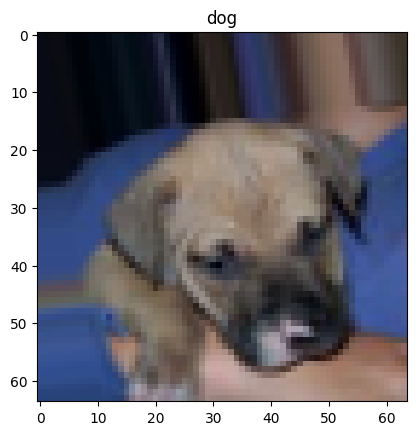

In [35]:
example_x, example_y = next(train_datagen.flow(x_train, y_train, batch_size=1))
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(CLASSES[int(example_y[i])])
    plt.show()

Nous pouvons maintenant recréer notre modèle et relancer l'entraînement.

In [36]:
model = Sequential()
## 1ère couche :
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2))

## 2ème couche :
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

## 3ème couche :
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

## 4ème couche :
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

## Flatten
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense

## Prédicteur
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(1, activation='sigmoid'))   # Couche de sortie

model.summary()

# AJOUTER EGALEMENT LA FONCTION DE COUT
model.compile(loss='bce',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

/opt/homebrew/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,673 (1.71 MB)

 Trainable params: 448,673 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4935 - loss: 0.6947 - val_accuracy: 0.5810 - val_loss: 0.6912
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5535 - loss: 0.6859 - val_accuracy: 0.6140 - val_loss: 0.6726
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6115 - loss: 0.6558 - val_accuracy: 0.6280 - val_loss: 0.6479
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6410 - loss: 0.6349 - val_accuracy: 0.6180 - val_loss: 0.6436
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6535 - loss: 0.6223 - val_accuracy: 0.6550 - val_loss: 0.6266
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6505 - loss: 0.6227 - val_accuracy: 0.6390 - val_loss: 0.6363
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6695 - loss: 0.6008 - val_accuracy: 0.6620 - val_loss: 0.6245
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6680 - loss: 0.6087 - val_accu

### Analyse des résultats

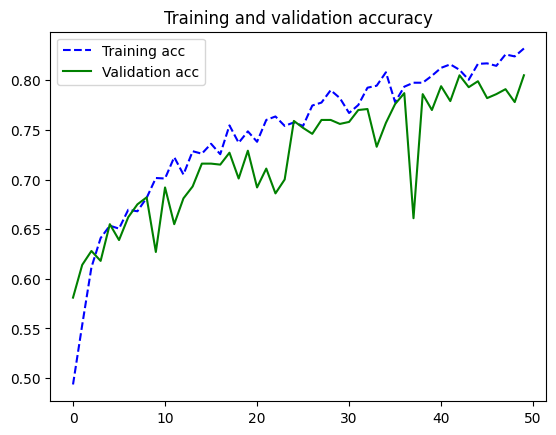

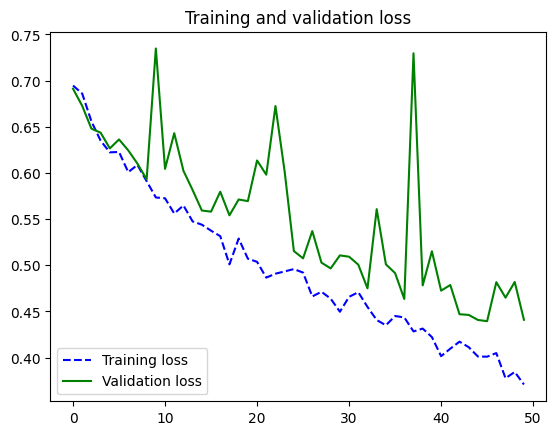

In [37]:
plot_training_analysis()

On voit clairement sur les courbes que l'on a limité le sur-apprentissage. Notez aussi d'ailleurs, et c'est important, que l'apprentissage est plus lent : le modèle met plus de temps à prédire correctement l'ensemble d'apprentissage. C'est normal, car on a en quelque sorte "complexifié le problème" en introduisant toutes ces déformations de nos images.
Cette forme de régularisation "par les données" s'ajoute aux autres méthodes que nous avons vues précédemment comme la régularisation L1/L2 des poids du réseau.  

Vous devriez maintenant atteindre des performances autour de 80% de précision sur l'ensemble de validation, ce qui est bien mais pas complètement satisfaisant : il faudrait pour continuer à s'améliorer probablement s'entraîner plus longtemps, mais également disposer de plus de données.

Une autre solution est d'utiliser le **Transfer Learning**.

## Transfer learning

L'une des raisons qui peut expliquer le fait que nos résultats soient décevants est que les premières couches de notre réseau convolutif, sensées détecter des caractéristiques utiles pour discriminer chiens et chats, n'ont pas appris de filtres suffisamment généraux à partir des 2000 images d'entraînement. Ainsi, même si ces filtres sont pertinents pour les 2000 images d'entraînement, il y a en fait assez peu de chances que ces filtres puissent bien fonctionner pour la généralisation sur de nouvelles données.

C'est la raison pour laquelle nous avons envie de réutiliser un réseau pré-entrainé sur une large base de données, permettant donc de détecter des caractéristiques qui généraliseront mieux à de nouvelles données.

Ci-dessous, un petit rappel sur le transfert d'apprentissage.

In [38]:
from IPython.display import IFrame
IFrame("https://video.polymny.studio/?v=8e4dd7c6-0417-4aee-932e-b766cf04a219/", width=640, height=360)

Dans cette partie, nous allons réutiliser un réseau célèbre, et d'ores et déjà entraîné sur la base de données ImageNet : le réseau VGG-16.

Commençons par récupérer les couches de convolution de ce réseau, et s'en remémorer  la composition.

In [39]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [40]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Nous pouvons extraire les caractéristiques, apprises par le réseau de neurones sur ImageNet, de notre base de données d'image de chiens et de chat. L'intérêt, par rapport à la première partie, est qu'il aurait été presque impossible de déduire ces caractéristiques "générales" (trouvées sur une immense base de données) depuis notre base de données trop réduite de 2000 images. En revanche, ces caractéristiques générales devraient se révéler utiles pour notre classifieur.

On peut lire sur la structure du réseau VGG résumée grâce à la fonction *summary* ci-dessus que le tenseur de sortie est de dimension $2 \times 2 \times 512$, autrement dit que le réseau prédit des caractéristiques de dimension $2 \times 2 \times 512$ à partir d'une image de taille $64 \times 64$.

On va redimensionner cette sortie dans un vecteur de dimension $2048 = 2 \times 2 \times 512$.

In [44]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 548ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 538ms/step


Nous pouvons maintenant définir un réseau de neurones simple qui va travailler directement sur les caractéristiques prédites par VGG.

In [45]:
# A COMPLETER
model = Sequential()
model.add(Dense(512, activation='relu', input_dim = train_features.shape[1]))   # Couche dense, à 512 neurones
model.add(Dense(1, activation='sigmoid'))   # Couche de sortie

model.summary()

# AJOUTER EGALEMENT LA FONCTION DE COUT
model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss='bce',
              metrics=['accuracy'])

# COMPLETER AVEC LES TENSEURS SUR LESQUELS EFFECTUER L'APPRENTISSAGE
history = model.fit(train_features, y_train,
                    epochs=20,
                    batch_size=16,
                    validation_data=(val_features, y_val))

/opt/homebrew/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,049,601 (4.00 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7180 - loss: 0.5212 - val_accuracy: 0.7550 - val_loss: 0.5175
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8155 - loss: 0.3973 - val_accuracy: 0.7880 - val_loss: 0.4601
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8565 - loss: 0.3379 - val_accuracy: 0.7850 - val_loss: 0.4703
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8655 - loss: 0.3063 - val_accuracy: 0.7770 - val_loss: 0.5280
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8870 - loss: 0.2700 - val_accuracy: 0.7850 - val_loss: 0.4820
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9140 - loss: 0.2289 - val_accuracy: 0.7680 - val_loss: 0.5213
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9195 - loss: 0.2073 - val_accuracy: 0.7710 - val_loss: 0.5839
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9455 - loss: 0.1694 - val_accuracy: 0.

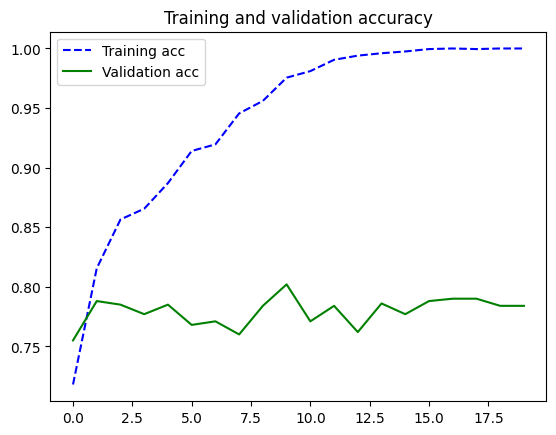

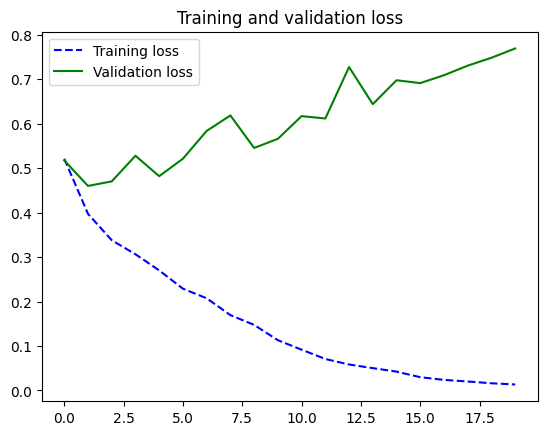

In [46]:
plot_training_analysis()

On observe à nouveau beaucoup de sur-apprentissage. Il faudrait trouver un moyen d'intégrer de l'augmentation de données.

Pour cela, on peut connecter notre petit réseau de neurones à l'extrémité de la base convolutionnelle de VGG. L'idée est qu'en réutilisant notre générateur de données augmentées, nous pourrons calculer les caractéristiques de VGG sur les données augmentées, et ainsi classifier ces caractéristiques plutôt que les caractéristiques de notre base de données uniquement.

## Intégration de l'augmentation de données

### Définition du nouveau modèle et entrainement

On commence par créer un nouveau modèle qui va s'appuyer sur la base convolutive de VGG, à laquelle on adjoint une couche dense et notre couche de sortie.

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [48]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,489 (58.13 MB)

 Trainable params: 15,239,489 (58.13 MB)

 Non-trainable params: 0 (0.00 B)

**Attention** : il est important de ne pas commander l'entraînement de la base convolutionnelle de VGG ! Nous ne voulons en aucun cas écraser les bonnes caractéristiques de VGG que nous cherchons justement à réutiliser ! Le réseau aurait en outre un grand nombre de paramètres, ce qui est justement ce que l'on veut éviter !

Pour cela nous pouvons utiliser l'attribut *trainable* : en le positionnant à *false*, nous pouvons geler les poids et en empêcher la mise à jour pendant l'entraînement.

In [49]:
conv_base.trainable = False
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,489 (58.13 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Observez le décompte des poids : le nombre de poids entraînable est maintenant de 500 000, contre 16 millions précédemment ; on ne va entrainer ici que les poids de notre couche dense et de la couche de sortie.

In [50]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=10,
                    )

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 262ms/step - accuracy: 0.6735 - loss: 0.6021 - val_accuracy: 0.7620 - val_loss: 0.4847
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 271ms/step - accuracy: 0.7330 - loss: 0.5288 - val_accuracy: 0.7840 - val_loss: 0.4657
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - accuracy: 0.7290 - loss: 0.5311 - val_accuracy: 0.7830 - val_loss: 0.4595
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.7425 - loss: 0.5103 - val_accuracy: 0.7850 - val_loss: 0.4651
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 253ms/step - accuracy: 0.7680 - loss: 0.4801 - val_accuracy: 0.7740 - val_loss: 0.4638
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - accuracy: 0.7555 - loss: 0.4826 - val_accuracy: 0.8010 - val_loss: 0.4456
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.7715 - loss: 0.4723 - val_accuracy: 0.7960 - val_loss: 0.4541
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.7555 - loss: 0

### Analyse des résultats du nouveau modèle

L'entraînement est beaucoup plus lent ! Il faut en effet générer les données augmentées, et leur faire traverser les couches de VGG à chaque itération de gradient. Ceci prend du temps !

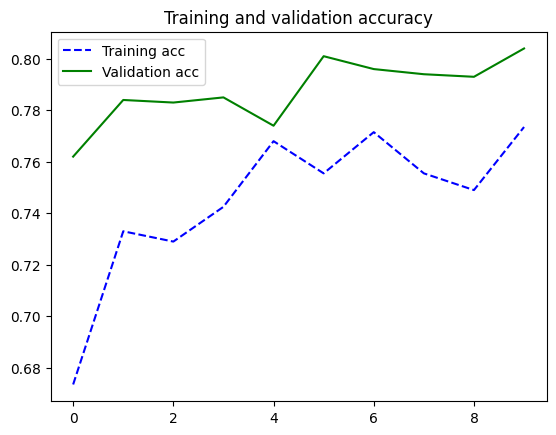

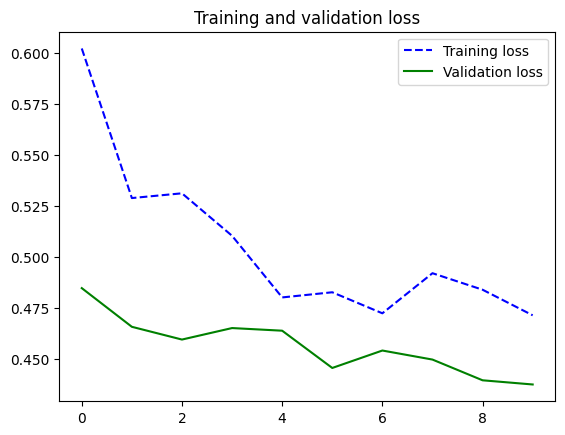

In [51]:
plot_training_analysis()

En revanche, on observe que l'on a bien limité le sur-apprentissage, ce qui était le but recherché. Les résultats sont un peu meilleurs mais pas complètement satisfaisants.

### Fine-tuning


Nous pouvons maintenant tester la dernière technique vue en cours : le **fine-tuning**. Pour cela, nous allons repartir du réseau que nous venons d'entraîner, mais nous allons débloquer l'entraînement des poids de l'ensemble du réseau. **ATTENTION : il est important de choisir un taux d'apprentissage très faible afin de ne pas réduire à néant les bénéfices des entraînements précédents.** L'objectif est simplement de faire évoluer les paramètres du réseau "à la marge", et ceci ne peut être fait qu'après la première étape de *transfer learning* précédente. Sans cela, les dernières couches ajoutées à la suite de la base convolutive, après leur initialisation aléatoire, auraient engendré de forts gradients qui auraient complètement détruit les filtres généraux de VGG.



On commence par réactiver l'entraînement des paramètres de la base convolutive de VGG :

In [52]:
conv_base.trainable = True
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,289,093 (62.14 MB)

 Trainable params: 15,239,489 (58.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,049,604 (4.00 MB)

In [53]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=10,
                    )

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 744ms/step - accuracy: 0.7855 - loss: 0.4734 - val_accuracy: 0.8210 - val_loss: 0.4209
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 151s 752ms/step - accuracy: 0.8140 - loss: 0.4058 - val_accuracy: 0.8440 - val_loss: 0.3624
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 778ms/step - accuracy: 0.8515 - loss: 0.3449 - val_accuracy: 0.8650 - val_loss: 0.3170
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 150s 748ms/step - accuracy: 0.8740 - loss: 0.3083 - val_accuracy: 0.8720 - val_loss: 0.3212
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 147s 736ms/step - accuracy: 0.8775 - loss: 0.2981 - val_accuracy: 0.8790 - val_loss: 0.2975
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 152s 762ms/step - accuracy: 0.8780 - loss: 0.2693 - val_accuracy: 0.8870 - val_loss: 0.2889
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 738ms/step - accuracy: 0.9045 - loss: 0.2295 - val_accuracy: 0.8810 - val_loss: 0.3081
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 147s 734ms/step - accuracy: 0.8830 -

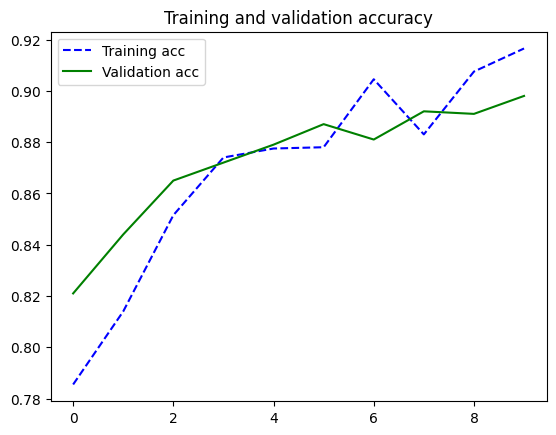

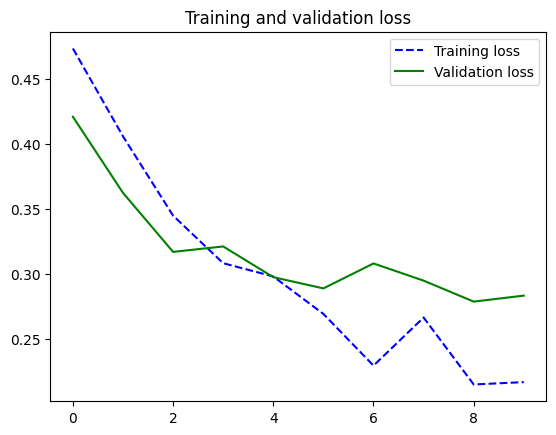

In [54]:
plot_training_analysis()

On atteint un bon résultat, proche des 90% de précision sur l'ensemble de validation, bien au-dessus des performances obtenues sans *transfer learning* ! Vous comprenez maintenant pourquoi en traitement d'image, cette technique est incontournable.

**S'il vous reste du temps** :

Vous pouvez maintenant reprendre le travail depuis le début en augmentant la résolution des images (par exemple $128 \times 128$). A l'issue du *transfer learning* et du *fine-tuning*, vous devriez dépasser les 95\% de précision sur l'ensemble de validation.

